In [10]:
import os
import time
import numpy as np
import pandas as pd
from radar.dataparsing.td_textdata_parser import read_columns
from scipy.fftpack import fft
from matplotlib import pyplot as plt

td_data = []

# Different Test Cases
# timeStampFolder = "2024-10-17_11-57-43.359" # Take-off (at least 4 drones)
# timeStampFolder = "2024-10-17_12-04-36.137" # Landing UAVs - for at least 2 UAVs
# timeStampFolder = "2024-10-17_15-59-35.092" # Up/Down Movement (for 5 UAVs)

# DJ Mini Tests - hovering overtop the radar tests, distances mentioned
# timeStampFolder = "2024-10-18_09-55-39.076 1.3m"
# timeStampFolder = "2024-10-18_09-59-12.941 5.0m"
timeStampFolder = "2024-10-18_10-02-03.580 15m"
# timeStampFolder = "2024-10-18_10-13-20.561 20m"
# timeStampFolder = "2024-10-18_10-10-43.904 29m"

directory_to_process = f"/data/radar/Oct17/{timeStampFolder}/TD"


# directory_to_process = f"output/2024-09-29_20-20-41/radar"

def process_data_from_folder(self):
        
        # List all files in the directory
        files = os.listdir(directory_to_process)
        
        # Filter the files based on the naming convention
        txt_files = [f for f in files if f.endswith('.txt')]
        
        # Sort the files if needed (optional)
        txt_files.sort()
        
        # Process each file one by one
        for file_name in txt_files:
            file_path = os.path.join(directory_to_process, file_name)
            new_fd_data = read_columns(file_path)
            td_data.append(new_fd_data.td_data)
        
            
process_data_from_folder(directory_to_process)
td_data = np.array(td_data)
I1_data = td_data[:, :, 0]  # Extract the I1 signal, which is the first column across all frames and range bins
Q1_data = td_data[:, :, 1]  # Extract the Q1 signal, which is the second column across all frames and range bins
I2_data = td_data[:, :, 2]  # Extract the I2 signal, which is the third column across all frames and range bins
Q2_data = td_data[:, :, 3]  # Extract the IQ2 signal, which is the fourth column across all frames and range bins
x1 = I1_data + 1j * Q1_data
x2 = I2_data + 1j * Q2_data

## Populate all the radar variables required:
TIME_STEP = 0.241
WAVELENGTH = 0.01233714
C = 299792458  # Speed of light (m/s)

f_0 = 24e9  # Center Frequency (Hz)
f_c = 24.500e9  # Center Frequency (Hz)
f_chirp = 4.14937759  # Chirp Sequence Frequency (Hz)
f_r = 750e6  # Ramp Frequency (Hz)
T_r = 0.241  # Duration of one cycle (s) - Chirp sequence
m_w = f_r / T_r  # Slope of the ramp (Hz/s)
n_r = I1_data.shape[0] # number of total chirps - assumes all have the same shape, which they should
n_s = I1_data.shape[1] # number of samples - assumes all have the same shape, which they should
T_M = T_r * n_r  # Total measurement time (s)
f_s = 1 / TIME_STEP

SINGLE_TO_PROCESS = I1_data

print(f"Num samples: {td_data.shape[0]}")

Num samples: 382


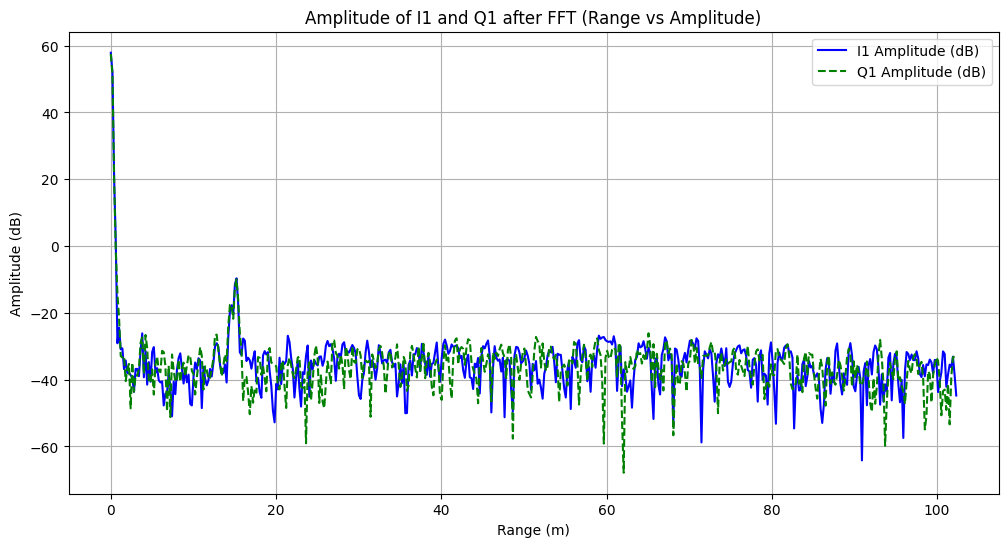

In [21]:
# Define a function to plot the I1 and Q1 amplitude (in dB) after FFT for a specific time window
def plot_I1_Q1_amplitude_after_fft(I_signal, Q_signal, num_samples, num_bins = 1024, range_resolution=0.199861, time_step=0.241):
    """
    Plots the amplitude (in dB) of the I1 and Q1 signals after performing FFT along the range bins.
    
    Parameters:
    td_data (numpy array): 3D array of shape (time_samples, range_bins, signals), e.g., (224, 1024, 4).
    range_resolution (float): Resolution in meters (default is 0.199861 meters).
    time_step (float): Time between chirps (s), default is 0.1 seconds.
    
    Returns:
    None: Displays the amplitude in dB of I1 and Q1 after FFT.
    """
    Nd, Nr = num_samples, num_bins  # Number of time samples (chirps) and range bins
    
    # Apply Hanning window to reduce spectral leakage
    window = np.hanning(Nr)
    I1_signal_windowed = I_signal * window[np.newaxis, :]
    Q1_signal_windowed = Q_signal * window[np.newaxis, :]
    
    # Perform FFT along the range bins for both I1 and Q1
    I1_fft = np.fft.fft(I1_signal_windowed, axis=1)
    Q1_fft = np.fft.fft(Q1_signal_windowed, axis=1)
    
    # Take the magnitude of the first half of the FFT results
    I1_amplitude = np.abs(I1_fft[:, :Nr//2])
    Q1_amplitude = np.abs(Q1_fft[:, :Nr//2])
    
    # Convert to dB scale
    I1_amplitude_db = 20 * np.log10(I1_amplitude)
    Q1_amplitude_db = 20 * np.log10(Q1_amplitude)
    
    # Define the range axis (based on range resolution)
    max_range = range_resolution * Nr
    range_axis = np.linspace(0, max_range/2, Nr//2)
    
    # Define the time axis (based on time step)
    time_axis = np.linspace(0, Nd * time_step, Nd)
    
    # Plot the I1 amplitude in dB
    plt.figure(figsize=(12, 6))
    plt.plot(range_axis, I1_amplitude_db[0], label='I1 Amplitude (dB)', color='blue')
    plt.plot(range_axis, Q1_amplitude_db[0], label='Q1 Amplitude (dB)', color='green', linestyle='--')
    
    plt.title('Amplitude of I1 and Q1 after FFT (Range vs Amplitude)')
    plt.xlabel('Range (m)')
    plt.ylabel('Amplitude (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_I1_Q1_amplitude_after_fft(I1_data, Q1_data, I1_data.shape[0], I1_data.shape[1], range_resolution=0.199861, time_step=0.241)
